In [114]:
import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path
import cv2

os.chdir('/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project')
model = YOLO("./2.weights/best.pt")

classes_fd = model.names
print(f"Face detection model is able to detect following classes:\n{classes_fd}")

Model is able to detect following classes:
{0: 'BABY', 1: 'EYE', 2: 'HEAD', 3: 'MOUTH', 4: 'NOSE'}


# Trained model

## Inference

In [24]:
test_dir = Path("test_samples")
test_samples = list(test_dir.iterdir())

output_dir = Path("2.test_output")
output_dir.mkdir(exist_ok=True)

res = []
for s in test_samples:
    result = model(s, conf=0.3, verbose=False)[0]
    res.append(result)
    
    out_path = output_dir / s.name
    im_with_boxes = result.plot()
    cv2.imwrite(str(out_path), im_with_boxes[..., ::-1])
print(f"INFERENCE FINISHED, {len(res)}/{len(test_samples)} file precessed")

INFERENCE FINISHED, 20/20 file precessed


# Extrapolate bbox and then create embedding
Each res is a `ultralytics.engine.results.Results object`

We are interested in bbox, in particular in ["baby", "head", "eye", "mouth", "nose"] 
* 'baby' -> 1/-1, 1 if present -1 otherwise
* 'head' -> x,y coordinates
* 'eye1' -> x,y coordinates if present, -1 otherwise
* 'eye2' -> x,y coordinates if present, -1 otherwise
* 'mouth' -> x,y coordinates if present, -1 otherwise
* 'nose' -> x,y coordinates if present, -1 otherwise

In [101]:
res[0].boxes

ultralytics.engine.results.Boxes object with attributes:

cls: tensor([0., 2., 3., 1., 1., 4.])
conf: tensor([0.9592, 0.9552, 0.9030, 0.8885, 0.8779, 0.7374])
data: tensor([[6.9273e-01, 6.2396e+00, 5.8253e+02, 4.7748e+02, 9.5915e-01, 0.0000e+00],
        [1.3565e+02, 2.0345e-01, 4.8581e+02, 3.9137e+02, 9.5523e-01, 2.0000e+00],
        [2.3040e+02, 2.6293e+02, 3.2699e+02, 3.2072e+02, 9.0298e-01, 3.0000e+00],
        [3.4770e+02, 1.8974e+02, 4.1047e+02, 2.2440e+02, 8.8849e-01, 1.0000e+00],
        [2.1715e+02, 1.5359e+02, 2.8017e+02, 1.8915e+02, 8.7793e-01, 1.0000e+00],
        [2.6005e+02, 1.9502e+02, 3.3532e+02, 2.5566e+02, 7.3737e-01, 4.0000e+00]])
id: None
is_track: False
orig_shape: (479, 584)
shape: torch.Size([6, 6])
xywh: tensor([[291.6100, 241.8617, 581.8345, 471.2442],
        [310.7316, 195.7885, 350.1580, 391.1700],
        [278.6963, 291.8277,  96.5842,  57.7863],
        [379.0881, 207.0682,  62.7700,  34.6595],
        [248.6586, 171.3723,  63.0145,  35.5554],
        [297

I exploit `xywhn` boxes, and in particular `xy` that represent coordinates of center

In [40]:
from ultralytics.engine.results import Boxes  

def embedding_builder(prediction: Boxes):
    '''
    DEBUG PURPOSE
    if prediction.xywhn.size()[0]>6:
        print(f"Warning, more than 6 features detected in the sample\n{prediction.cls}")
    '''
    
    embedding_position= {
        "BABY" : 0,
        "HEAD": 1,
        "EYE": (3, 5),
        "MOUTH": 7,
        "NOSE": 9
    }
    
    vec = np.full(11, -1.0, dtype=float)
    for bbox, cls in zip(prediction.xywhn, prediction.cls):
        class_label = classes_fd[cls.item()]
        if class_label == "BABY":
            pos = embedding_position[class_label]
            
            vec[pos] = 1
        elif class_label == "EYE":
            pos = embedding_position[class_label][0] if vec[embedding_position[class_label][0]] == -1 else embedding_position[class_label][1]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]
        else:
            pos = embedding_position[class_label]
            
            vec[pos] = bbox[0]
            vec[pos+1] = bbox[1]    
    
    return vec

In [34]:
data = []

for p in res:
    prediction = p.boxes
    vec = embedding_builder(prediction)
    data.append(vec)

data = np.vstack(data)    

Warning, more than 6 features detected in the sample
tensor([3., 2., 1., 4., 0., 1., 1.])


In [35]:
print(f"Now each photo is represented by a 11 element embedding:\n{data}")

Now each photo is represented by a 11 element embedding:
[[          1     0.53207     0.40874     0.64912     0.43229     0.42579     0.35777     0.47722     0.60924     0.50973     0.47043]
 [          1     0.63797     0.39953     0.63319     0.48469     0.55218     0.34476     0.52267     0.50276     0.55986     0.45424]
 [          1     0.47678     0.42684     0.51032     0.29309      0.4234     0.53494     0.57401     0.48569      0.5117     0.42256]
 [          1     0.58741     0.49003     0.49488      0.5049      0.3563     0.65432     0.42614     0.60599     0.42922     0.52686]
 [          1     0.65788     0.22118     0.60501     0.22954     0.74247     0.23451     0.67023     0.32456     0.67359     0.26776]
 [          1     0.65167     0.24353     0.64986     0.35681     0.60477      0.2484     0.57966      0.3642     0.61114     0.33131]
 [          1     0.55443     0.12244     0.50099     0.12225      0.6028     0.12665     0.54812     0.19001     0.55027     0.14474

## Extract info from JSON file
* filename : img_id
* img_id: label

In [17]:
import numpy as np
from ultralytics import YOLO
import os
from pathlib import Path
import cv2

In [39]:
import json
os.chdir('/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project')

file_imgid = {}
imgid_label = {}
file_label = {}

classes_mlp = {}

with open("onback_onstomach_dataset/_annotations.coco.json", "r") as f:
    dataset = json.load(f)
    
    for img in dataset["images"]:
        file_imgid[img["file_name"]] =img["id"]
    
    for label in dataset["annotations"]:
        imgid_label[label["image_id"]] = label["category_id"]
    
    for cls in dataset["categories"]:
        classes_mlp[cls["name"]]=cls["id"]
    del classes_mlp["Positions"]

for file, img_id in file_imgid.items():
    if img_id in imgid_label.keys():
        file_label[file] = imgid_label[img_id]      

In [19]:
print(f"Dataset to train on_bck/ on_stomach contains {len(file_label)} samples.")
print(f"Dataset categories: {classes_mlp}")

Dataset to train on_bck/ on_stomach contains 2068 samples.
Dataset categories: {'Safe': 1, 'Unsafe': 2}


## Extract features(face detection) and create embedding

In [36]:
os.chdir('/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project')
model = YOLO("./2.weights/best.pt")

classes_fd = model.names
print(f"Face detection model is able to detect following classes:\n{classes_fd}")

Face detection model is able to detect following classes:
{0: 'BABY', 1: 'EYE', 2: 'HEAD', 3: 'MOUTH', 4: 'NOSE'}


In [1]:
os.chdir('/home/terra/Documents/AI_engineering/SIDS-project/python_project/SIDS_revelation_project')
onback_onstomach_dataset = Path("onback_onstomach_dataset/")
X = []
y = []

for img in onback_onstomach_dataset.glob("*.jpg"):
    if img.name in file_label.keys():
        #DEBUG
        if len(y)%100 == 0:
            print(f"{int(len(y)*100/len(file_label))}%-->    {len(y)} / {len(file_label)} embeddings created")
        #DEBUG    
        result = model(img, conf=0.3, verbose=False)[0]
        prediction = result.boxes
        
        vec = embedding_builder(prediction)
        X.append(vec)
        y.append(file_label[img.name])
    print(f"FINISH, {len(y)} embeddings created")

NameError: name 'os' is not defined

Save new dataset in a .csv
New dataset is equivalent to:
* x, 11 elements embedding
* y, one scalar target

In [43]:
import csv

with open("onback_onstomach_dataset/processed_dataset.csv", "w", newline='') as f:
    writer = csv.writer(f)
    for xi, yi in zip(X, y):
        writer.writerow(list(xi) + [yi])

Then in order to extract X and y from .csv and load them in numpy arrays

import numpy as np

data = np.loadtxt("processed_dataset.csv", delimiter=",")
X = data[:, :-1]
y = data[:, -1]

# Attempt with random forest....no buono

In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import numpy as np

# Convert to NumPy arrays (if not already)
X_array = np.array(X)
y_array = np.array(y)

# Split into train/test sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_array, y_array, test_size=0.2, random_state=42)

# Create the classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the classifier
clf.fit(X_train, y_train)

# Predict on the test set
y_pred = clf.predict(X_test)

# Evaluate
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.717391304347826
Classification Report:
              precision    recall  f1-score   support

           1       0.76      0.92      0.83       310
           2       0.33      0.12      0.18       104

    accuracy                           0.72       414
   macro avg       0.55      0.52      0.51       414
weighted avg       0.65      0.72      0.67       414



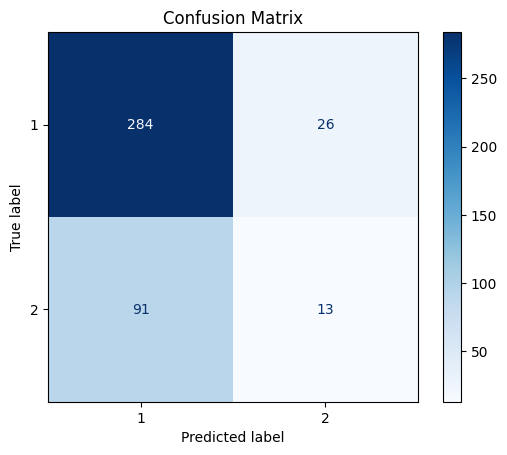

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)

# Visualizza con etichette (opzionale: specifica classi)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
disp.plot(cmap=plt.cm.Blues)

plt.title("Confusion Matrix")
plt.show()
